In [100]:
# -*- coding: utf-8 -*-
"""
Created on Mon Nov  4 07:02:45 2024

@author: robberto
"""

from astropy.io import fits
import matplotlib.pyplot as plt

import os
import shutil
import glob
import numpy as np
import pandas as pd
import copy
import heapq

from scipy.signal import find_peaks
import cv2

## """ Instantiate the class with the correct directory name"""

In [102]:
data_path = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
from Class_SAMOS import SAMOS
SAMOS = SAMOS(data_path) 

working on the directory: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI


### Check the files you want to process here
https://www.stsci.edu/~robberto/Main/SAMOS/Run_October2024/SAMI/QL_20241017/overview.html

## SELECT A TARGET AND INSPECT THE FILES YOU MAY WANT TO USE. ANNOTATE BELOW

In [105]:
# DATA ANALYSIS 
target_name = "ABELL3120_manual_Mask_T00_Low_Red"

"""
=> Night 20241017
TARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]
FLATS  = target.028.fits [2s], calibration.029.fits [2s]
ARC_Ne = calibration.033.fits [10s]
ARC_HgAr = calibration.030.fits [8s]
ARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  
ARC_Ne_DMDoff = calibration.034.fits [8s]
ARC_HgAr_DMDoff = calibration.036.fits [8s]
ARC_HgArNe_DMDoff = calibration.035.fits [8s]

=> Night 20241016
BIAS =  bias.055.fits - bias.074.fits 

=> Night 20241016
FLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]
"""

'\n=> Night 20241017\nTARGET = target.025.fits [600s], target.026.fits [600s], target.027.fits [600s]\nFLATS  = target.028.fits [2s], calibration.029.fits [2s]\nARC_Ne = calibration.033.fits [10s]\nARC_HgAr = calibration.030.fits [8s]\nARC_HgArNe = calibration.031.fits   [10s], calibration.032.fits [8s]  \nARC_Ne_DMDoff = calibration.034.fits [8s]\nARC_HgAr_DMDoff = calibration.036.fits [8s]\nARC_HgArNe_DMDoff = calibration.035.fits [8s]\n\n=> Night 20241016\nBIAS =  bias.055.fits - bias.074.fits \n\n=> Night 20241016\nFLATS_DMDoff = flat019.fits [0.1s]; flat.020.fits[1s]\n'

In [106]:
#CREATE A WORKING DIRECTORY WITH THE TARGET NAME IF IT DOES NOT EXIST
working_directory ="/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS"
working_directory = os.path.join(working_directory,target_name)

# if the folder already exists in new directory
if not os.path.exists(working_directory):
        os.makedirs(working_directory)
os.chdir(working_directory) 
print(working_directory)

#DATA DIRECTORIES WHERE THE SAMOS FILES ARE STORED
data_directory = "/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA/RUN2/SAMI"
data_directory_17 = data_directory + "/20241017"
data_directory_16 = data_directory + "/20241016"
data_directory_09 = data_directory + "/20241009"

/Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red


## READ THE FITS FILE

In [108]:
i_s = 0
fits_file = working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_s)

hdul = fits.open(fits_file)
hdr = hdul[0].header
hdul.info()
print(hdr)
slits= [hdr['i0'], hdr['i1'], hdr['i2'], hdr['i3']]
print(slits)
data1 = hdul[1].data
i_flat = hdul[2].data
i_lines = hdul[3].data
mask_in  = hdul[4].data
curvature= hdul[5].data 
x = curvature[0][:]
px = curvature[1][:]
print(mask_in)
#plt.imshow(mask_in, origin='lower', cmap='gray',aspect='15.5') 
#plt.imshow(mask_in, origin='lower', cmap='gray',vmin=0, vmax=50,aspect='15.5') 
print(px[3000:3200])
mask_out = 1-mask_in
dx = data1.shape[1] ; print(dx)
dy = data1.shape[0]


Filename: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red/spec_000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 42)   float64   
  3  LINES         1 ImageHDU         8   (4094, 42)   float64   
  4  MASK          1 ImageHDU         8   (4094, 42)   float64   
  5  CURVATURE     1 ImageHDU         8   (4094, 2)   float64   
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  SLIT    =                    0              

## Extract the flats

(42, 4094)


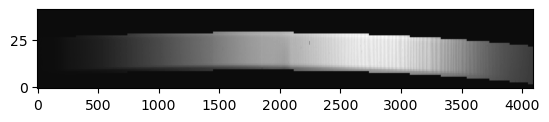

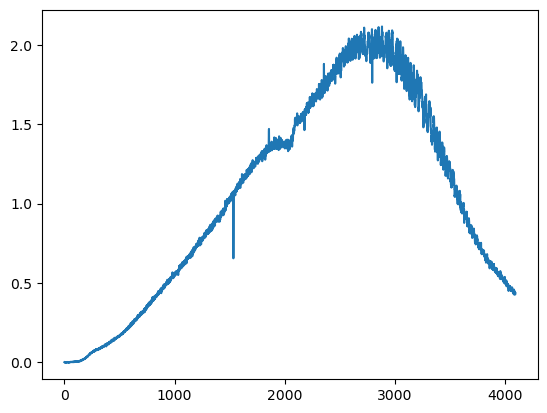

(42, 4094)


In [110]:

i_flat_bck = i_flat * mask_out
i_flat_slit = i_flat * mask_in
print(i_flat_slit.shape)
for ix in range(dx):
    i_flat_slit[:,ix] = i_flat_slit[:,ix] - np.mean(i_flat_bck[:,ix])
i_flat_slit *= mask_in   
i_flat_slit = i_flat_slit/np.mean(i_flat_slit[i_flat_slit != 0])
plt.imshow(i_flat_slit, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(i_flat_slit[20,:])
plt.show()
print(i_flat_slit.shape)

(42, 4094)
(42, 4094) (42, 4094)


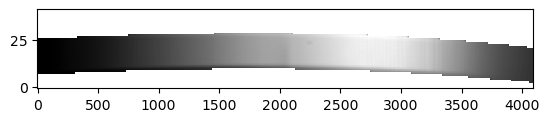

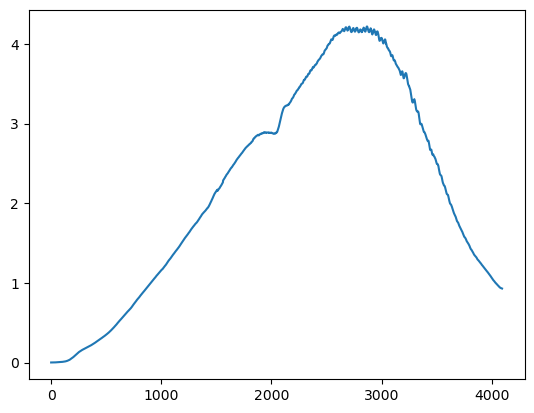

(42, 4094)


In [111]:
# Creating a kernel for numpy 
kernel2 = np.ones((1, 50), np.float32)/50
print(i_flat_slit.shape)  
# Applying the filter 
i_flat_slit_smooth = cv2.filter2D(src=i_flat_slit, ddepth=-1, kernel=kernel2) 
print(i_flat_slit.shape,i_flat_slit_smooth.shape)

#flat_slit_smooth *= mask_in   
i_flat_slit_smooth = i_flat_slit_smooth/np.mean(i_flat_slit_smooth[i_flat_slit_smooth != 0])
i_flat_slit_smooth *= mask_in
i_flat_slit_smooth[i_flat_slit_smooth ==  0] = np.nan
plt.imshow(i_flat_slit_smooth, origin='lower', cmap='gray',aspect='15.5') 
plt.show()
plt.plot(i_flat_slit_smooth[20,:])
plt.show()
print(i_flat_slit_smooth.shape)

### Flat field the image

(42, 4094)


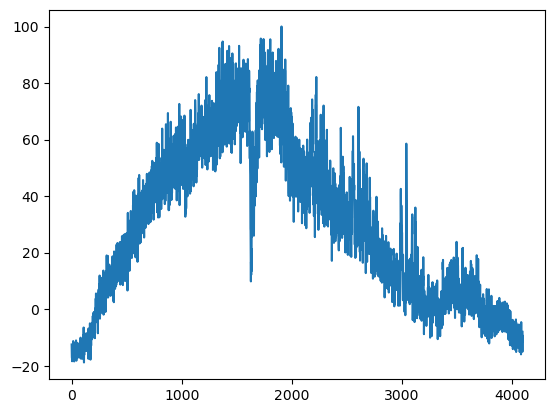

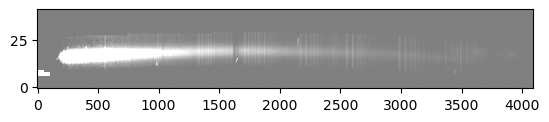

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          2.12031287  0.21084239  7.66170159  7.29688825
 13.67337942 19.50148216 17.08778302 14.65541762  6.20908384  6.30030802
  1.51748563  0.2885267   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]


In [113]:
i_spectra_slit  = data1 * mask_in
i_spectra_bck = data1 * mask_out
for ix in range(dx):
    i_spectra_slit[:,ix] = i_spectra_slit[:,ix] - np.mean(i_spectra_bck[:,ix])
i_spectra_slit *= mask_in   
print(i_spectra_slit.shape)

plt.plot(i_spectra_slit[20,:])
plt.show()
i_spectra_slit_ff = i_spectra_slit / i_flat_slit_smooth
i_spectra_slit_ff = np.nan_to_num(i_spectra_slit_ff,posinf=0, neginf=0)
i_spectra_slit_ff[i_spectra_slit_ff<0]=0
#print(spectra_slit_ff)
plt.imshow(i_spectra_slit_ff*mask_in, origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()
print(i_spectra_slit_ff[:,2000])

# SUBTRACT SKY

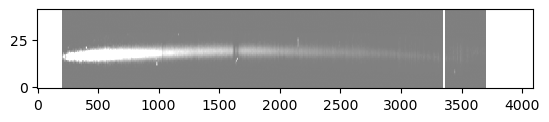

In [115]:
i_spectra_slit_ff_OH = copy.deepcopy(i_spectra_slit_ff)
for ix in range(dx):#2000,2001):
#for ix in range(2000,2001):

    #print(ix)
    v=i_spectra_slit_ff_OH[:,ix]
    #print(v)
    v=v[v != 0]
    #print(v)
    vs = np.sort(v)
    #print('\nvs = ',vs[1:8])
    mmm = np.median(vs[3:8])
    #print(mmm)
    i_spectra_slit_ff_OH[:,ix] = i_spectra_slit_ff[:,ix] - mmm
    i_spectra_slit_ff_OH[i_spectra_slit_ff_OH<0]=0    
#print(spectra_slit_ff_rect_OH[:,i])
plt.imshow(i_spectra_slit_ff_OH,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()
#plt.plot(i_spectra_slit_ff_OH[25,:])


#plt.plot(i_spectra_slit_ff_rect[14,2000:3000]-i_spectra_slit_ff_rect[26,2000:3000])

# RECTIFY THE SPECTRUM

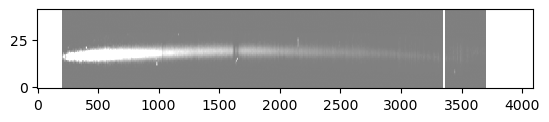

(84, 4094) (84, 4094)


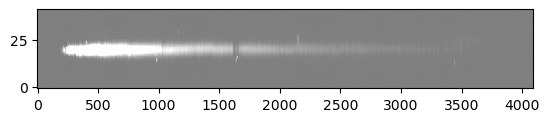

9.0

In [117]:
"""
i_spectra_slit_ff_OH_rect = i_spectra_slit_ff_OH * 0
for ix in range(dx):
    i_spectra_slit_ff_rect[:,ix] = np.roll( i_spectra_slit_ff[:,ix],-int(p(ix))+20)
"""
plt.imshow(i_spectra_slit_ff_OH,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()

#from scipy import signal
#hy  = i_spectra_slit_ff.shape[0]
#hx  = i_spectra_slit_ff.shape[1]
#i_spectra_slit_ff_rect = np.zeros([hy*4,hx])
#for ix in range(dx):
#    #f = signal.resample(i_spectra_slit_ff[:,ix], hy*4)
#    #i_spectra_slit_ff_rect[:,ix] = np.roll( f,-int(p(ix)*4)+20*4)
#    i_spectra_slit_ff_rect[:,ix] = signal.resample(i_spectra_slit_ff[:,ix], hy*4)
#plt.imshow(i_spectra_slit_ff_rect,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
##plt.imshow(i_spectra_slit_ff_rect,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
#plt.show()

import scipy.ndimage
hy  = i_spectra_slit_ff_OH.shape[0]
hx  = i_spectra_slit_ff_OH.shape[1]
order=2
i0 = np.zeros([hy*order,hx])  #out resampled 
#print(i0.shape,np.isnan(np.min(i0)))
#plt.imshow(i0,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 

i1 = scipy.ndimage.zoom(i_spectra_slit_ff_OH, (order,1), order=1) #input resampled
i1=np.nan_to_num(i1, nan=0.0)
#print(i1.shape,np.isnan(np.min(i01)))
#plt.imshow(i1,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
#plt.show()

i1[i1<0]=0
#plt.imshow(i1,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
#plt.show()
print(i0.shape,i1.shape)
from scipy import signal
for ix in range(dx):
    f = signal.resample(i_spectra_slit_ff_OH[:,ix], hy*order)
    i0[:,ix] = np.roll( i1[:,ix],-int(order*px[ix])+21*order)#hy/2*order))        

i_spectra_slit_ff_OH_rect = scipy.ndimage.zoom(i0, (1/order,1), order=order)
plt.imshow(i_spectra_slit_ff_OH_rect,origin='lower', cmap='gray',vmin=-50, vmax=50,aspect='15.5') 
plt.show()
i_spectra_slit_ff_OH_rect[i_spectra_slit_ff_OH_rect<0.01]=0
(slits[1]+slits[2])/2-slits[1]
#print(i_spectra_slit_ff_OH_rect[:,2000])



## spectrum_1d = i_spectra_slit_ff_rect_OH[:,800:1500].mean(axis=1)
plt.figure(figsize=(10,3))
#plt.ylim([0,200])
plt.plot(spectrum_1d) 
plt.show()


### Look at the 1-d spectrum


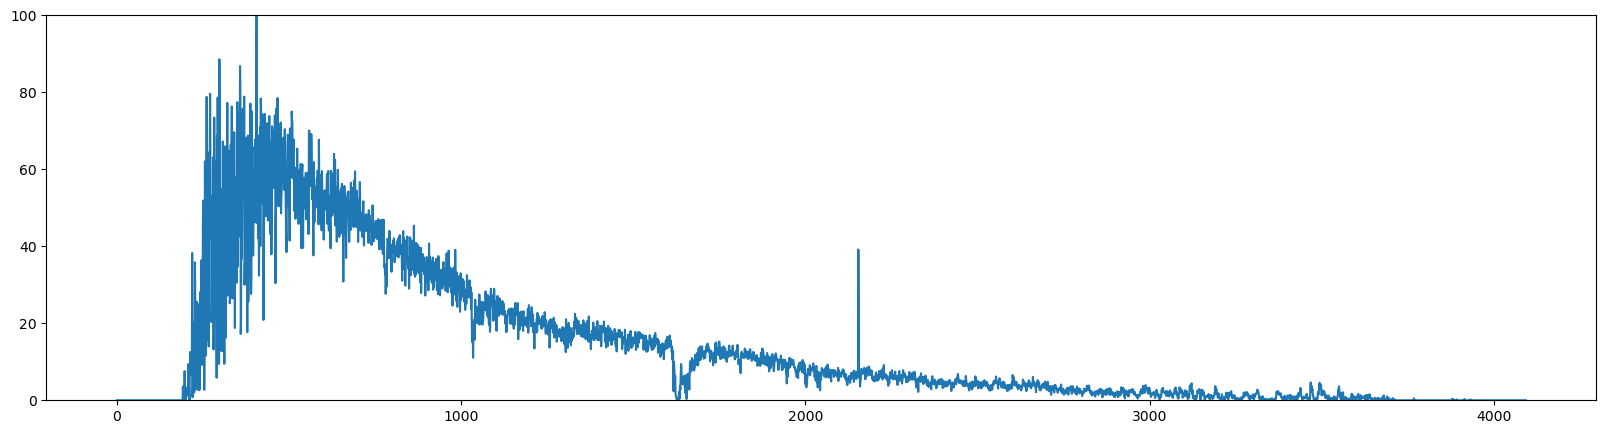

In [120]:
i_spectrum_1d = i_spectra_slit_ff_OH_rect[17:27,:].mean(axis=0)
plt.figure(figsize=(20,5))
plt.ylim([0,100])
plt.plot(i_spectrum_1d) 
plt.show()


## CREATE FITS DATACUBES

In [122]:
fits_file = working_directory+'/spec_{i_s:03.0f}.fits'.format(i_s=i_s)
hdulist = fits.open(fits_file)

#add 2d spectrum
final2d_hdu = fits.ImageHDU(data=i_spectra_slit_ff_OH_rect, name= "SPEC-2d")
hdulist.append(final2d_hdu)
#add 1d spectrum
spec1d = [x,i_spectrum_1d]
final1d_hdu = fits.ImageHDU(data=spec1d, name= "SPEC-1d")
hdulist.append(final1d_hdu)

hdulist.info()
hdulist.close()


Filename: /Users/robberto/Library/CloudStorage/Box-Box/My Documents - Massimo Robberto/@Massimo/_Science/2. Projects_HW/SAMOS/SAMOS_DATA_ANALYSIS/ABELL3120_manual_Mask_T00_Low_Red/spec_000.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       9   ()      
  1  DATA          1 ImageHDU         8   (4094, 42)   float64   
  2  FLAT          1 ImageHDU         8   (4094, 42)   float64   
  3  LINES         1 ImageHDU         8   (4094, 42)   float64   
  4  MASK          1 ImageHDU         8   (4094, 42)   float64   
  5  CURVATURE     1 ImageHDU         8   (4094, 2)   float64   
  6  SPEC-2D       1 ImageHDU         8   (4094, 42)   float64   
  7  SPEC-1D       1 ImageHDU         8   (4094, 2)   float64   


### LINE CALIBRATION - TO RUN SET i_slit = 10 above (randomly selected...)

In [124]:
i_slit = 10 #make sure this has been set also above

arc_good_slit  = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_in
arc_good_bck = arc_good[slits[i_slit][0]:slits[i_slit][3],:] * mask_out
plt.imshow(arc_good_slit, origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

arc_good_rect = arc_good_slit * 0
for i in range(dx):
    arc_good_rect[:,i] = np.roll(arc_good_slit[:,i],-int(p(i))+20)
plt.imshow(arc_good_rect,origin='lower', cmap='gray',vmin=-50, vmax=150,aspect='15.5') 
plt.show()

plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
#from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
print(lll)
lll_np=lll.to_numpy()
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
for i in range(len(xxx)):
    plt.text(xxx[i], yyy[i]*1.2, str(xxx[i]), fontsize = 12)
plt.show()




NameError: name 'arc_good' is not defined

In [ ]:
#HgArNe_pix = [1119, 1140, 1194, 1258, 1291, 1463, 1492, 1545, 2031, 2104, 2280, 2405, 2533,2623, 2659]#,2719]
#HgArNe_lam = [6506, 6532, 6508, 6532, 6717, 6929, 6963, 7032, 7635, 7724, 7948, 8103, 8264,8377, 8424]#,8424]
HgArNe_pix = [246,  504, 523,   576,  654,  762,  779,  818,  836,  881,  920,  
              978, 1017, 1032, 1119, 1140, 1194, 1260, 1291, 1463, 1492, 1545, 1661, 1719, 2031, 2104, 2280, 2415, 2533,2623, 2659]#,2719]
HgArNe_lam = [5460.7500,
              5769.6100,
              5790.6700, 
              5852.4879, 
              5944.8342, 
              6074.3377, 
              6096.1631, 
              6143.5939, 
              6163.5939, 
              6217.2812, 
              6266.4950,
              
              6334.4278, 
              6382.9917, 
              6402.2480, 
              6506.5281, 
              6532.8822, 
              6598.9529, 
              6678.2762, 
              6717.0430, 
              6929.4673,
              
              6965.4310, 
              7032.4131, 
              7173.9381,
              7245.1666, #24-1719
              7635.1060, #25-2031
              7724.2070, #26-2104 [Ar]
              7948.1760, #27-2280 [Ar]
              8115.3110, #28-2415 [Ar]
              8264.5220, #29-2533 [Ar]
              8377.6080, 
              8424.6480  #31-2659 [Ar]
                ]
plt.scatter(HgArNe_pix,HgArNe_lam, label='Data Points')

coefficients = np.polyfit(HgArNe_pix,HgArNe_lam, 3)
print("Linear Fit Coefficients:", coefficients)

# Create polynomial function
p = np.poly1d(coefficients)

#fishing for the lines we have used...
print(p(2946))

plt.plot(HgArNe_pix, p(HgArNe_pix), label='Linear Fit', color='red')
plt.legend()
plt.show()

plt.plot(HgArNe_pix, p(HgArNe_pix)-HgArNe_lam, label='ResidualLinear Fit', color='red')
plt.legend()
plt.show()

#CREATE INVERSE POLYNOMIAL
coefficients_wl2pix = np.polyfit(HgArNe_lam,HgArNe_pix, 3)
print("Linear Fit Coefficients:", coefficients_wl2pix)

# Create polynomial function
p_wl2pix = np.poly1d(coefficients_wl2pix)
print(p_wl2pix(6266))

## Parenthesis to save and reload the polynomial coeefficients

In [ ]:
print(coefficients,p)
print(working_directory)
np.savetxt(working_directory+'/wl_poly_coefficients.txt', coefficients)
np.savetxt(working_directory+'/wl_poly_coefficients_wl2pix.txt', coefficients_wl2pix)
#check
coefficients_in = np.loadtxt(working_directory+'/wl_poly_coefficients.txt', dtype=float)
print(coefficients_in)
coefficients ==  coefficients_in
p(2000)



In [ ]:
plt.figure(figsize=(20,5))
#plt.yscale('log')
plt.ylim([10,4e4])
plt.plot(arc_good_rect.mean(axis=0))


#find the lines
from scipy.signal import find_peaks 
import findpeaks
fp = findpeaks.findpeaks(lookahead=1)
#results = fp.fit(vector)
lines_df = fp.fit(arc_good_rect.mean(axis=0))
lines= lines_df['df'][ (lines_df['df']['peak'] == True)] 
lll = lines[lines['y'] > 100 ]
xxx = lll.x.to_numpy()
yyy = lll.y.to_numpy()
print(lll)
#lll_np=lll.to_numpy()
#v_slit_up=np.delete(v_slit_up, 16, axis=0)
#print(lll_np[:,1], len(lll_np[:,1]))
#print(lines)
ax = fig.add_subplot(1, 1, 1)
plt.scatter(xxx,yyy)
counter=0
for i in HgArNe_pix:
    #print(i)
    z = lll.y[lll.x == i]
    #print(z)
    z1=z.to_numpy()[0]
    plt.text(int(i), np.squeeze(z1)+1.5E3, str(int(HgArNe_lam[counter])), fontsize = 12)
    counter+=1
plt.show()

## FINALLY REDUCED SPECTRUM

In [ ]:
x=np.arange(dx)
wl = p(x)
xc = 20#(slits[i][2]+slits[i][1])/2.
#spectrum_1d = spectra_slit_ff_rect_OH[17:25,:].mean(axis=0)
for dist in range(4):
    plt.figure(figsize=(20,5))
    plt.yscale('log')
    plt.ylim([0,1500])
    spectrum_1d = i_spectra_slit_ff_rect_OH[22-dist:23+dist,:].mean(axis=0)
    plt.plot(wl,spectrum_1d) 
    plt.show()



# Plot using SPECUTILS

https://specutils.readthedocs.io/en/stable/spectrum1d.html

In [ ]:
import astropy.units as u
from specutils import Spectrum1D

flux = spectrum_1d * u.adu
wavelength = wl * u.AA
spec1d = Spectrum1D(spectral_axis=wavelength, flux=flux)
ax = plt.subplots()[1]  
ax.plot(spec1d.spectral_axis, spec1d.flux)  
ax.set_xlabel("Dispersion")  
ax.set_ylabel("Counts")  

print(spec1d.spectral_axis)
#to write
spec1d.write(working_directory+'/spec_{i_slit:03.0f}.fits'.format(i_slit=i_slit),overwrite=True)  
#to read
spec1d = Spectrum1D.read(working_directory+'/spec_{i_slit:03.0f}.fits'.format(i_slit=i_slit))  

In [ ]:
working_directory+'/spec_{i_slit:03.0f}.fits'.format(i_slit=i_slit)

# GET THE SPECTRA FOR THE OTHER LAMPS
# LEFT AS AN EXERCISE


In [ ]:
#inverse solution
coefficients_1 = np.polyfit(HgArNe_lam,HgArNe_pix, 3)
print("Linear Fit Coefficients:", coefficients_1)

# Create polynomial function
p_1 = np.poly1d(coefficients_1)


Ar_lines = [696.54, 706.72, 714.70, 727.20, 738.40, 750.39, 763.51, 772.38, 794.82, 811.53,]
Hg_lines = [253.65, 296.73, 302.15, 313.16, 334.15,	404.66, 365.02, 407.78, 435.83,	546.07,	576.96,	579.07]
HgAr_lam= [6965.431, 7067.218, 7147.042, 7272.936, 7383.980, 7503.869, 7514.652, 7635.106, 7723.761, 7948.176,  8006.157, 8014.786, 8103.6930, 8115.3110,  8264.5, 8424.7, 8521.4, 8668.0, 9123.0, 9225.0]
#Ne_lines = 
print(p_1(HgAr_lam))



## APPENDIX: BUILDING THE P-FLATS

Pixel flats are obtained when two flats of different brightness (e.g. exposure time) are bias subtracted and then divided; 
after division by the ration of the exposure times, the image should be around 1 average, with salt-pepper noise indicative of the relative response of the pixels. To be repeated multiple times to beat down the readnoise.

We run thi experiment on the first night, and the format of the image was later changed so these are not useful for processing data taken later.

In [ ]:
#FIRST STEP: READ AND MOVE THE FILES
File_type = "FLAT QUARTZ"
File_NR = '019'
file_01  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_01)

File_NR = '020'
file_10  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_10)

File_type = "FLAT QUARTZ"
File_NR = '041'
file_bias  = os.path.join(data_directory_09,'flat.'+File_NR+'.fits')
print(file_bias)


#SECOND STEP: READ AND AVERAGE
hdu = SAMOS.read_SAMI_mosaic(file_01)
flat_01_data = hdu.data
hdu.data = flat_01_data

hdu1 = SAMOS.read_SAMI_mosaic(file_10)
flat_10_data = hdu1.data
hdu1.data = flat_10_data

hdu1 = SAMOS.read_SAMI_mosaic(file_bias)
bias_data = hdu1.data
hdu1.data = bias_data

flat_01_data_bias = flat_01_data - bias_data
flat_10_data_bias = flat_10_data - bias_data
flat = np.divide(flat_10_data_bias,flat_01_data_bias,out=np.full_like(flat_10_data_bias, 10), where=flat_01_data_bias!=0 )/10.
print(flat.shape)

#DISPLAY
image = flat
median = np.median(flat)
stddev = np.std(flat)
z0 = median-stddev
z1 = median+stddev

SAMOS.display_image(flat,zmin=z0,zmax=z1)